# Penerapan PCA dan ADASYN pada Dataset Ecoli  

Ketentuan Tugas:
- Tampilkan data dalam scatter plot menggunakan PCA. PCA mentransformasi data menjadi dimensi rendah (2D).
- Lakukan penyeimbangan data menggunakan ADASYN dan SMOTE.
- Ploting data dari data yang diimbangkan menggunakan PCA, tandai data data hasil generatenya.

## Import Library

In [1]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from collections import Counter
from sklearn.manifold import TSNE

## Koneksi ke MySQL dan Ambil Dataset

In [2]:
# Koneksi ke MySQL
mysql_conn = pymysql.connect(
    host="mysql-3c768195-aqbilbaraka.d.aivencloud.com",
    user="avnadmin",
    password="AVNS_WV9i6KvYoQZ3s6FclWP",
    database="defaultdb",
    port=16932,
    ssl={"ssl": {}}
)

# Query tabel ecoli
query_mysql = "SELECT * FROM defaultdb.ecoli"
df = pd.read_sql(query_mysql, mysql_conn)

# Lihat data
df.head()


OperationalError: (2003, "Can't connect to MySQL server on 'mysql-3c768195-aqbilbaraka.d.aivencloud.com' ([Errno 11001] getaddrinfo failed)")

## Identifikasi fitur & label, pembersihan ringan

In [3]:
# Identifikasi kolom non-numeric
print("Kolom & dtypes:")
print(df.dtypes)

# Cari kolom label (kelas). Logika: pilih kolom bertipe object/string dengan nunique < n
possible_labels = [c for c in df.columns if df[c].dtype == object or df[c].dtype.name == 'category']
label_col = None
for c in possible_labels:
    if df[c].nunique() < len(df):
        label_col = c
        break

# Jika tidak ketemu, kamu harus set manual
if label_col is None:
    # contohnya: label_col = 'class'    # ganti jika perlu
    raise ValueError("Tidak menemukan kolom label otomatis. Set 'label_col' manual sesuai dataset (mis. 'class').")

print("Terpilih sebagai label:", label_col)

# Pilih fitur numerik (exclude id / label)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Kadang dataset UCI menyertakan index/sequence name sebagai kolom object unik - pastikan mengeluarkannya
print("Kolom numerik digunakan untuk PCA/ADASYN:", num_cols)

Kolom & dtypes:
id         int64
mcg      float64
gvh      float64
lip      float64
chg      float64
aac      float64
alm1     float64
alm2     float64
class     object
dtype: object
Terpilih sebagai label: class
Kolom numerik digunakan untuk PCA/ADASYN: ['id', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']


## Pra-pemrosesan fitur: drop missing, scale, encode label

In [4]:
# Buat salinan kerja
df_proc = df.copy()

# Drop rows dengan missing pada fitur numerik (atau lakukan imputasi bila ingin)
df_proc = df_proc.dropna(subset=num_cols)
print("After dropna shape:", df_proc.shape)
label_col = df.columns[-1]

# X (fitur numerik) dan y (label)
X = df_proc[num_cols].values
y = df_proc[label_col].values

# Encode label ke integer untuk ADASYN & plotting
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
print("Class mapping:", dict(enumerate(class_names)))

# Standardize fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


After dropna shape: (336, 9)
Class mapping: {0: 'cp', 1: 'im', 2: 'imL', 3: 'imS', 4: 'imU', 5: 'om', 6: 'omL', 7: 'pp'}


## Preprocessing Data

In [5]:
# Pisahkan fitur & target
X = df.drop(columns=["class"])
y = df["class"]

# Encode label target (class → angka)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Distribusi awal:", Counter(y_enc))


Distribusi awal: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})


## PCA 2D & scatter plot (sebelum balancing)

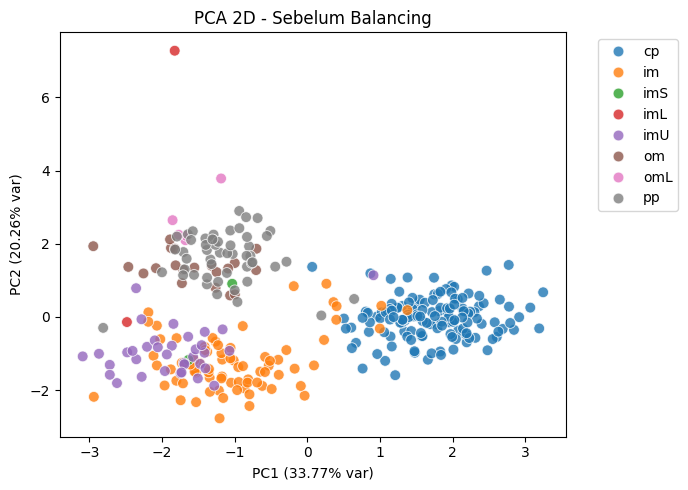

In [6]:
# Fit PCA pada data asli (2 komponen)
pca = PCA(n_components=2, random_state=42)
X_pca_before = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_pca_before[:,0], y=X_pca_before[:,1],
    hue=y, palette="tab10", s=60, edgecolor="w", alpha=0.8
)
plt.title("PCA 2D - Sebelum Balancing")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

## Cek distribusi kelas sebelum balancing

In [7]:
orig_counts = pd.Series(y).value_counts()
print("Counts before balancing:")
print(orig_counts)


Counts before balancing:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


## Lakukan balancing menggunakan ADASYN dan SMOTE

### Data Awal Sebelum Resampling

Distribusi awal: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})


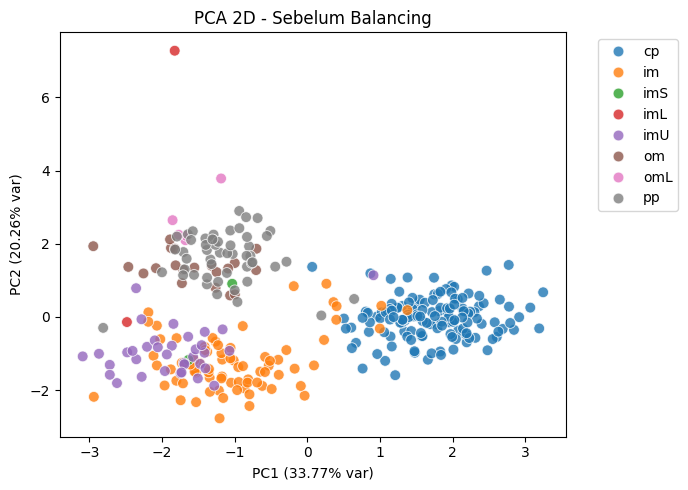

In [8]:
print("Distribusi awal:", Counter(y_enc))

# PCA pada data asli
X_pca_before = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_pca_before[:,0], y=X_pca_before[:,1],
    hue=y, palette="tab10", s=60, edgecolor="w", alpha=0.8
)
plt.title("PCA 2D - Sebelum Balancing")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


### Oversampling dengan ADASYN


In [9]:
# Oversampling pakai ROS
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_scaled, y_enc)

print("Distribusi setelah ROS:", Counter(y_ros))

# Oversampling lanjutan pakai ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=1) 
X_res, y_res = adasyn.fit_resample(X_ros, y_ros)

print("Distribusi setelah ADASYN:", Counter(y_res))

Distribusi setelah ROS: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})
Distribusi setelah ADASYN: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})


### Oversampling dengan SMOTE


In [10]:
# Oversampling dengan SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X_scaled, y_enc)

print("Shape sebelum:", X_scaled.shape, "→ sesudah:", X_smote.shape)
print("Distribusi setelah SMOTE:", Counter(y_smote))


Shape sebelum: (336, 8) → sesudah: (1144, 8)
Distribusi setelah SMOTE: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})


### PCA Sesudah ADASYN


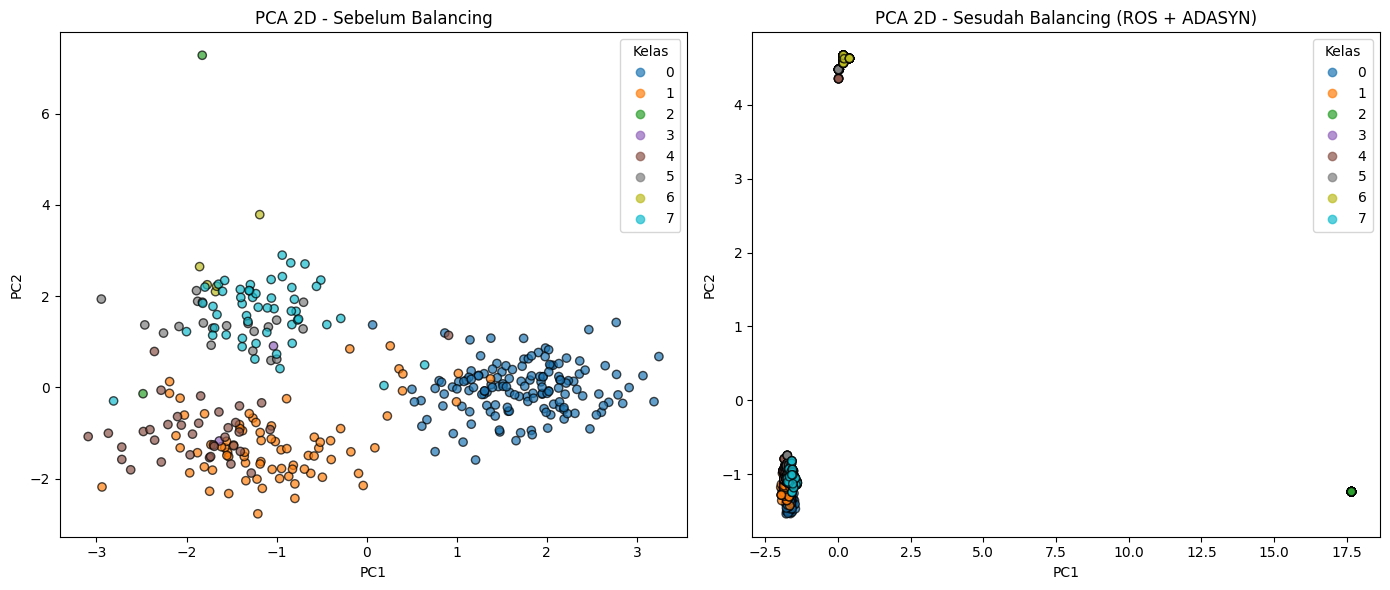

In [11]:
pca = PCA(n_components=2, random_state=42)

# PCA data asli (sebelum balancing)
X_pca_before = pca.fit_transform(X_scaled)

# PCA data setelah balancing
X_pca_after = pca.fit_transform(X_res)

# Plot side-by-side
plt.figure(figsize=(14,6))

# Plot sebelum balancing
plt.subplot(1,2,1)
scatter1 = plt.scatter(
    X_pca_before[:,0], X_pca_before[:,1],
    c=y_enc, cmap="tab10", alpha=0.7, edgecolor="k"
)
plt.title("PCA 2D - Sebelum Balancing")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*scatter1.legend_elements(), title="Kelas")

# Plot sesudah balancing
plt.subplot(1,2,2)
scatter2 = plt.scatter(
    X_pca_after[:,0], X_pca_after[:,1],
    c=y_res, cmap="tab10", alpha=0.7, edgecolor="k"
)
plt.title("PCA 2D - Sesudah Balancing (ROS + ADASYN)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*scatter2.legend_elements(), title="Kelas")

plt.tight_layout()
plt.show()

### PCA Sesudah SMOTE


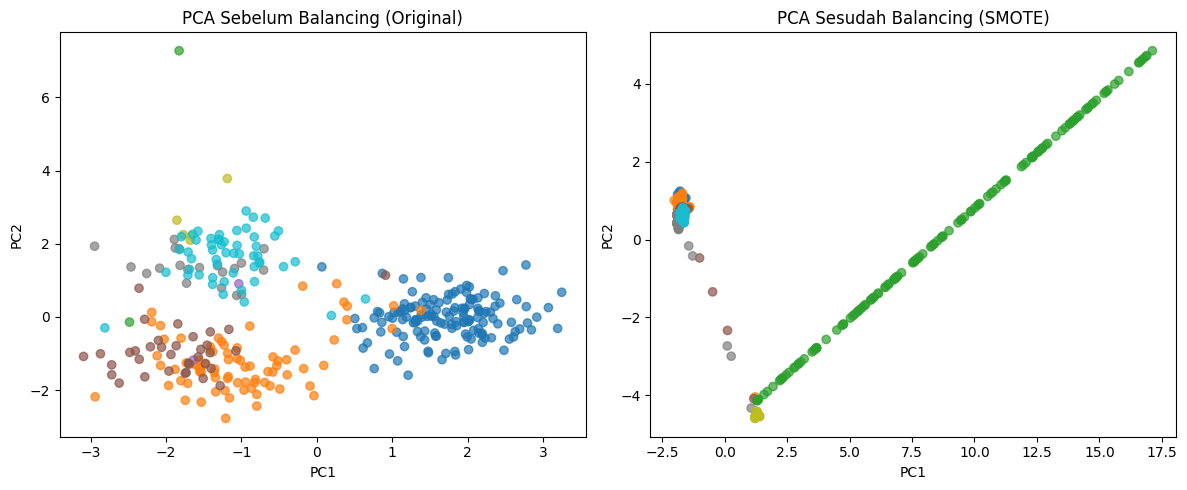

In [12]:
# Transformasi PCA
X_pca_smote = pca.fit_transform(X_smote)

plt.figure(figsize=(12,5))

# Sebelum balancing
plt.subplot(1,2,1)
plt.scatter(X_pca_before[:,0], X_pca_before[:,1], 
            c=y_enc, cmap="tab10", alpha=0.7)
plt.title("PCA Sebelum Balancing (Original)")
plt.xlabel("PC1"); plt.ylabel("PC2")

# Sesudah balancing dengan SMOTE
plt.subplot(1,2,2)
plt.scatter(X_pca_smote[:,0], X_pca_smote[:,1], 
            c=y_smote, cmap="tab10", alpha=0.7)
plt.title("PCA Sesudah Balancing (SMOTE)")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()


## Visualisasi PCA Sesudah Balancing dengan ADASYN DAN SMOTE

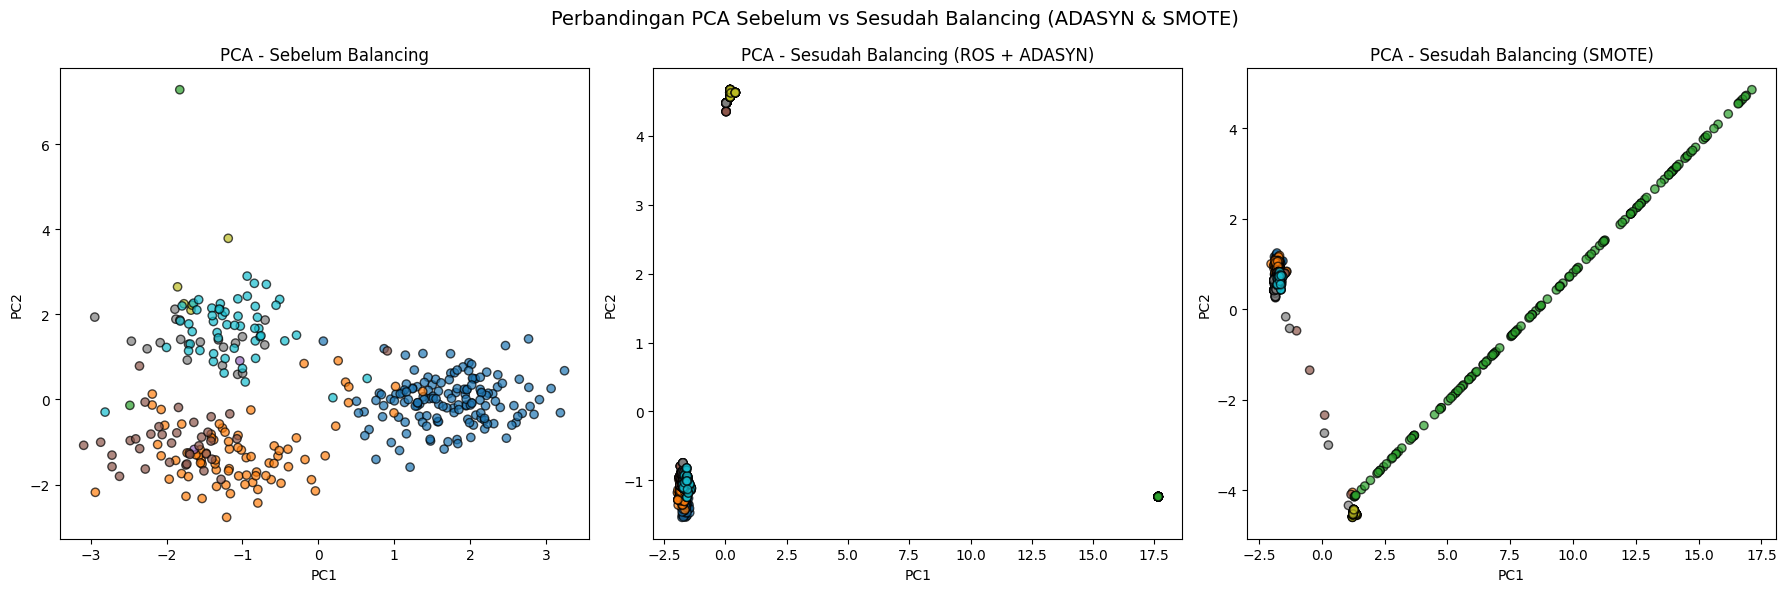

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# --- Sebelum balancing ---
axes[0].scatter(
    X_pca_before[:,0], X_pca_before[:,1],
    c=y_enc, cmap="tab10", alpha=0.7, edgecolor="k"
)
axes[0].set_title("PCA - Sebelum Balancing")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# --- Sesudah balancing (ROS + ADASYN) ---
axes[1].scatter(
    X_pca_after[:,0], X_pca_after[:,1],
    c=y_res, cmap="tab10", alpha=0.7, edgecolor="k"
)
axes[1].set_title("PCA - Sesudah Balancing (ROS + ADASYN)")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

# --- Sesudah balancing (SMOTE) ---
axes[2].scatter(
    X_pca_smote[:,0], X_pca_smote[:,1],
    c=y_smote, cmap="tab10", alpha=0.7, edgecolor="k"
)
axes[2].set_title("PCA - Sesudah Balancing (SMOTE)")
axes[2].set_xlabel("PC1"); axes[2].set_ylabel("PC2")

plt.suptitle("Perbandingan PCA Sebelum vs Sesudah Balancing (ADASYN & SMOTE)", fontsize=14)
plt.tight_layout()
plt.show()


## Perbandingan Distribusi Kelas Sebelum dan Sesudah Balancing

### Barplot

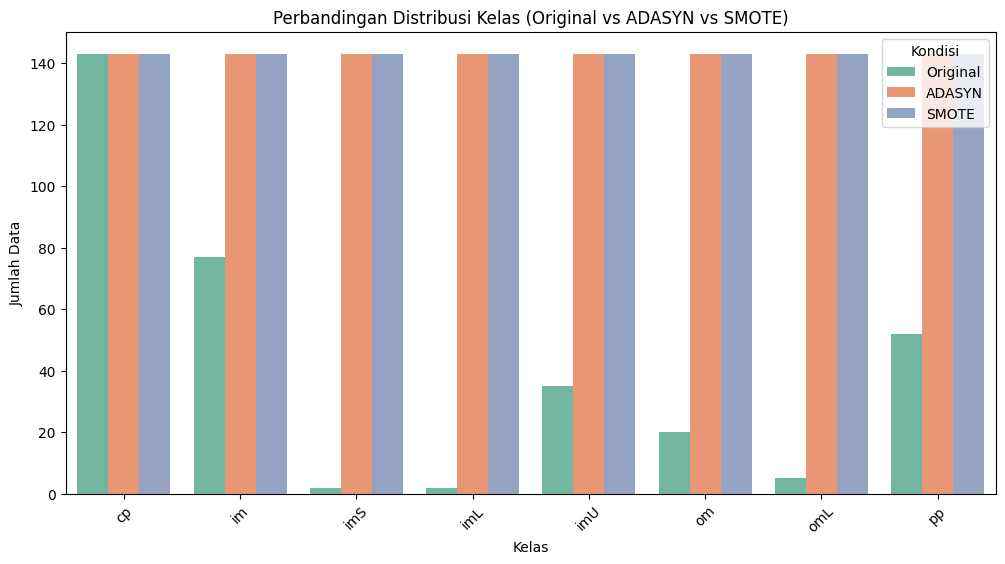

Distribusi Original: {'cp': 143, 'im': 77, 'imS': 2, 'imL': 2, 'imU': 35, 'om': 20, 'omL': 5, 'pp': 52}
Distribusi ADASYN : {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}
Distribusi SMOTE  : {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}


,Kelas,Original,ADASYN,SMOTE
0,cp,143,143,143
1,im,77,143,143
2,imS,2,143,143
3,imL,2,143,143
4,imU,35,143,143
5,om,20,143,143
6,omL,5,143,143
7,pp,52,143,143


In [14]:
# Hitung distribusi
dist_before = Counter(y_enc)
dist_adasyn = Counter(y_res)
dist_smote = Counter(y_smote)

# Mapping indeks ke nama kelas asli
class_labels = {i: name for i, name in enumerate(le.classes_)}

# Ubah keys Counter agar pakai nama kelas
dist_before_named = {class_labels[k]: v for k, v in dist_before.items()}
dist_adasyn_named = {class_labels[k]: v for k, v in dist_adasyn.items()}
dist_smote_named  = {class_labels[k]: v for k, v in dist_smote.items()}

# Buat DataFrame perbandingan
df_dist = pd.DataFrame({
    "Kelas": list(dist_before_named.keys()),
    "Original": list(dist_before_named.values()),
    "ADASYN": [dist_adasyn_named[k] for k in dist_before_named.keys()],
    "SMOTE": [dist_smote_named[k] for k in dist_before_named.keys()]
})

# Ubah ke long format
df_melted = df_dist.melt(id_vars="Kelas", var_name="Kondisi", value_name="Jumlah")

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=df_melted, x="Kelas", y="Jumlah", hue="Kondisi", palette="Set2")
plt.title("Perbandingan Distribusi Kelas (Original vs ADASYN vs SMOTE)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.legend(title="Kondisi")
plt.show()

# Print distribusi dalam angka
print("Distribusi Original:", dist_before_named)
print("Distribusi ADASYN :", dist_adasyn_named)
print("Distribusi SMOTE  :", dist_smote_named)

# Tabel ringkasan
display(df_dist)

### Pairplot PCA

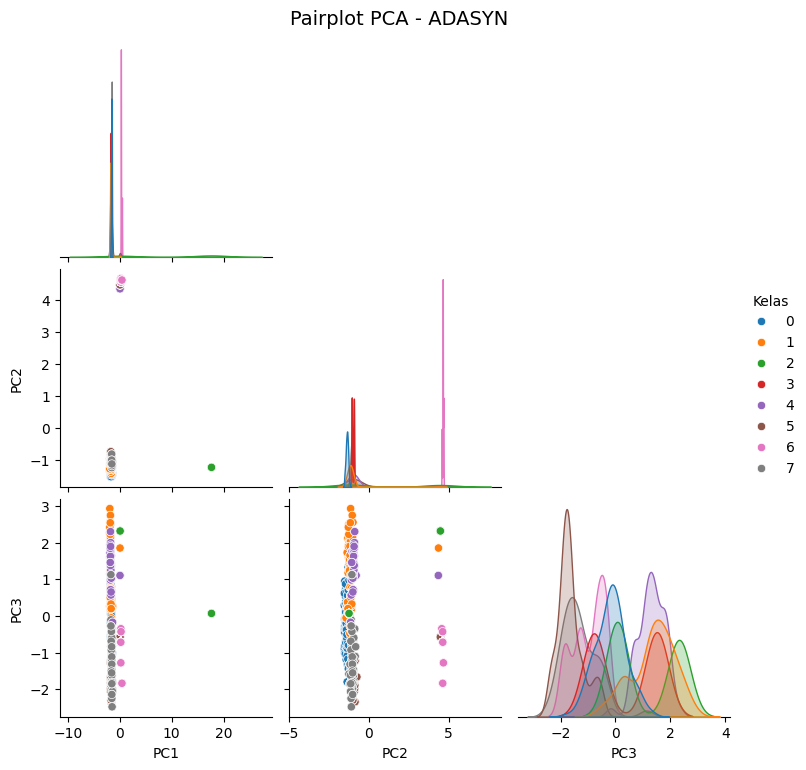

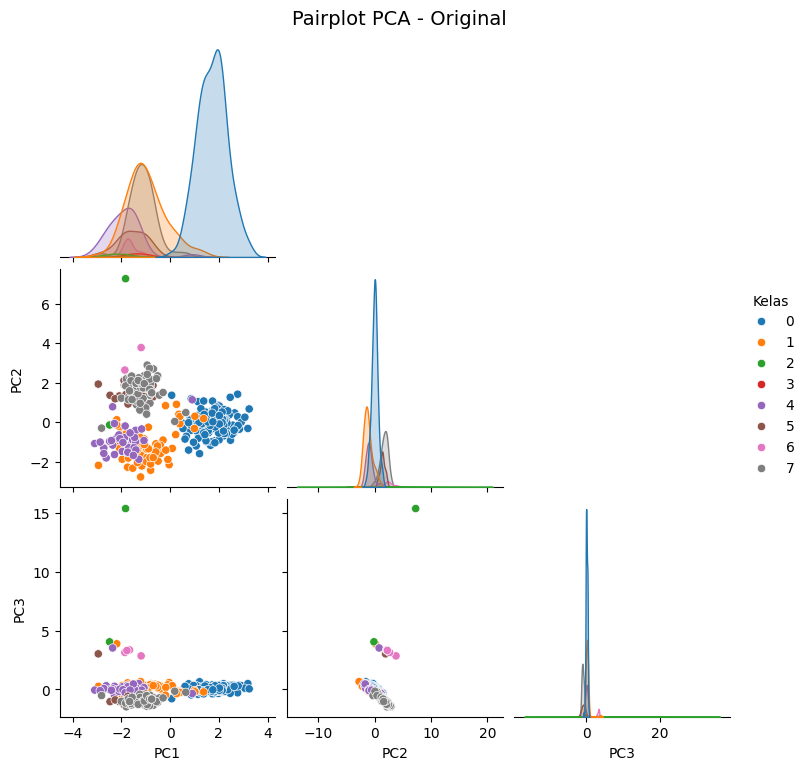

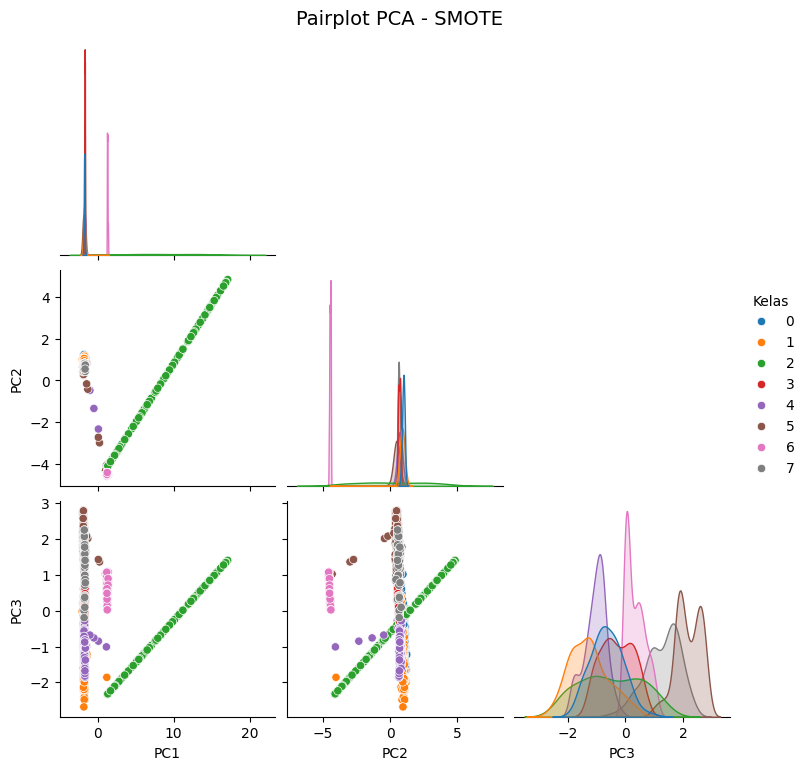

In [15]:
# Ambil 3 komponen PCA untuk bisa pairplot
pca = PCA(n_components=3, random_state=42)

# Transformasi data
X_pca_orig = pca.fit_transform(X_scaled)
X_pca_adasyn = pca.fit_transform(X_res)
X_pca_smote = pca.fit_transform(X_smote)

# Buat DataFrame untuk digabungkan
df_orig = pd.DataFrame(X_pca_orig, columns=["PC1","PC2","PC3"])
df_orig["Kelas"] = y_enc
df_orig["Kondisi"] = "Original"

df_adasyn = pd.DataFrame(X_pca_adasyn, columns=["PC1","PC2","PC3"])
df_adasyn["Kelas"] = y_res
df_adasyn["Kondisi"] = "ADASYN"

df_smote = pd.DataFrame(X_pca_smote, columns=["PC1","PC2","PC3"])
df_smote["Kelas"] = y_smote
df_smote["Kondisi"] = "SMOTE"

# Gabungkan semua
df_all = pd.concat([df_orig, df_adasyn, df_smote], ignore_index=True)

# Pairplot
for kondisi, df_subset in df_all.groupby("Kondisi"):
    sns.pairplot(
        df_subset,
        vars=["PC1","PC2","PC3"],
        hue="Kelas",
        palette="tab10",
        diag_kind="kde",
        corner=True
    )
    plt.suptitle(f"Pairplot PCA - {kondisi}", y=1.02, fontsize=14)
    plt.show()



### t-SNE Visualization

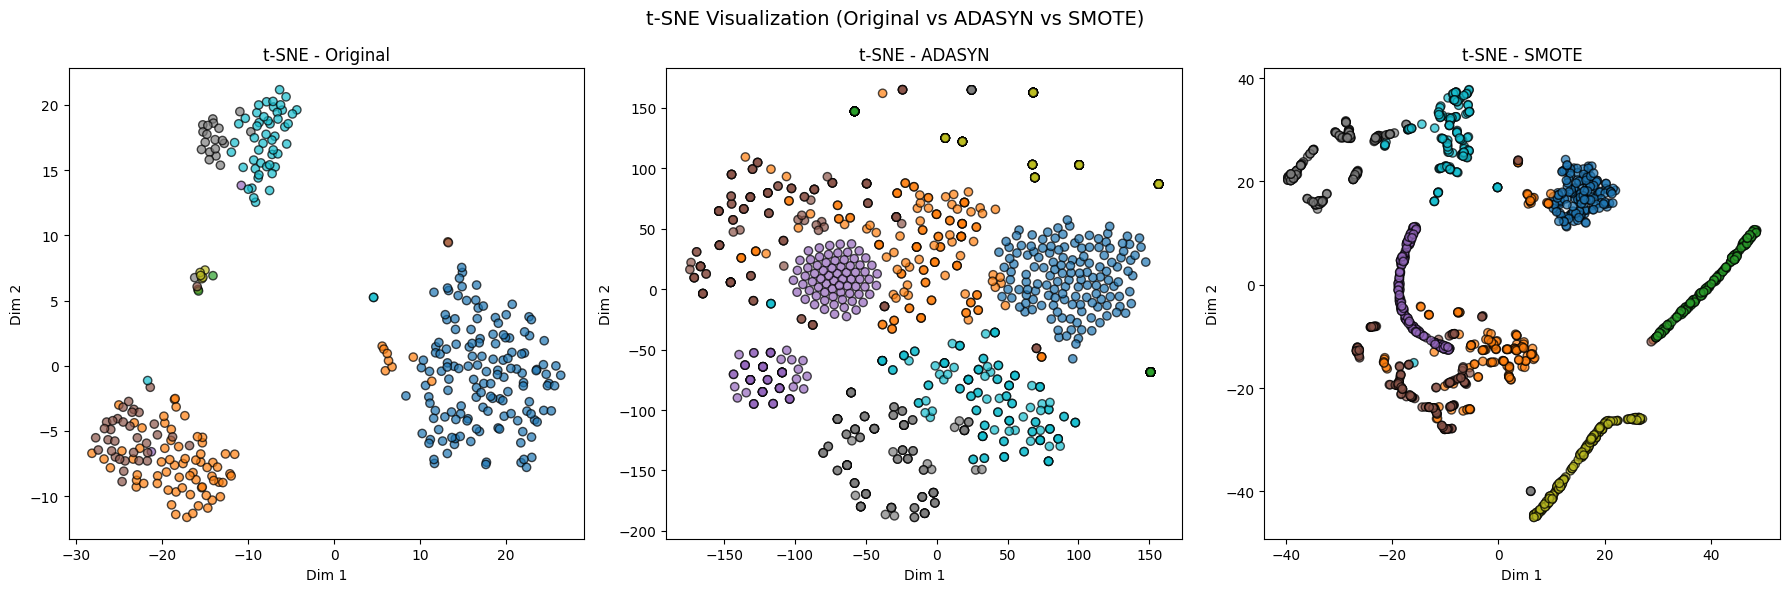

In [16]:
# Jalankan t-SNE (2 dimensi)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

X_tsne_orig = tsne.fit_transform(X_scaled)
X_tsne_adasyn = tsne.fit_transform(X_res)
X_tsne_smote = tsne.fit_transform(X_smote)

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Original
axes[0].scatter(
    X_tsne_orig[:,0], X_tsne_orig[:,1],
    c=y_enc, cmap="tab10", alpha=0.7, edgecolor="k"
)
axes[0].set_title("t-SNE - Original")
axes[0].set_xlabel("Dim 1"); axes[0].set_ylabel("Dim 2")

# ADASYN
axes[1].scatter(
    X_tsne_adasyn[:,0], X_tsne_adasyn[:,1],
    c=y_res, cmap="tab10", alpha=0.7, edgecolor="k"
)
axes[1].set_title("t-SNE - ADASYN")
axes[1].set_xlabel("Dim 1"); axes[1].set_ylabel("Dim 2")

# SMOTE
axes[2].scatter(
    X_tsne_smote[:,0], X_tsne_smote[:,1],
    c=y_smote, cmap="tab10", alpha=0.7, edgecolor="k"
)
axes[2].set_title("t-SNE - SMOTE")
axes[2].set_xlabel("Dim 1"); axes[2].set_ylabel("Dim 2")

plt.suptitle("t-SNE Visualization (Original vs ADASYN vs SMOTE)", fontsize=14)
plt.tight_layout()
plt.show()

### Heatmap Distribusi Kelas

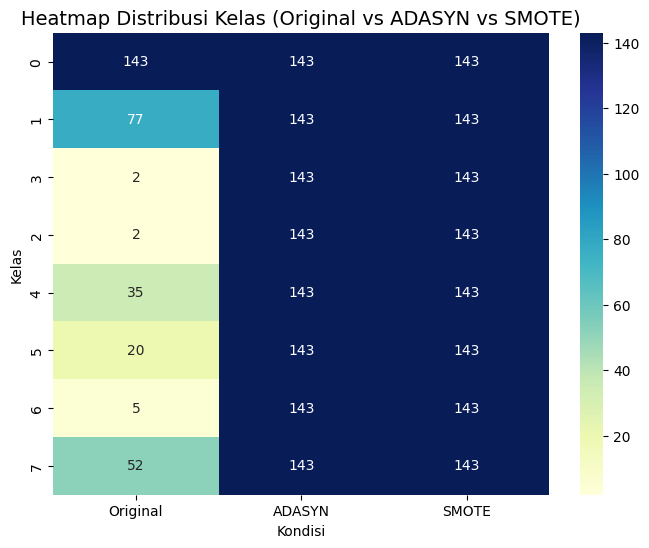

   Original  ADASYN  SMOTE
0       143     143    143
1        77     143    143
3         2     143    143
2         2     143    143
4        35     143    143
5        20     143    143
6         5     143    143
7        52     143    143


In [17]:
# Hitung distribusi kelas
dist_before = Counter(y_enc)
dist_adasyn = Counter(y_res)
dist_smote = Counter(y_smote)

# Buat DataFrame untuk heatmap
df_heatmap = pd.DataFrame({
    "Original": pd.Series(dist_before),
    "ADASYN": pd.Series(dist_adasyn),
    "SMOTE": pd.Series(dist_smote)
}).fillna(0).astype(int)

plt.figure(figsize=(8,6))
sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="YlGnBu", cbar=True)

plt.title("Heatmap Distribusi Kelas (Original vs ADASYN vs SMOTE)", fontsize=14)
plt.xlabel("Kondisi")
plt.ylabel("Kelas")
plt.show()

print(df_heatmap)

### Pie Chart Distribusi Kelas

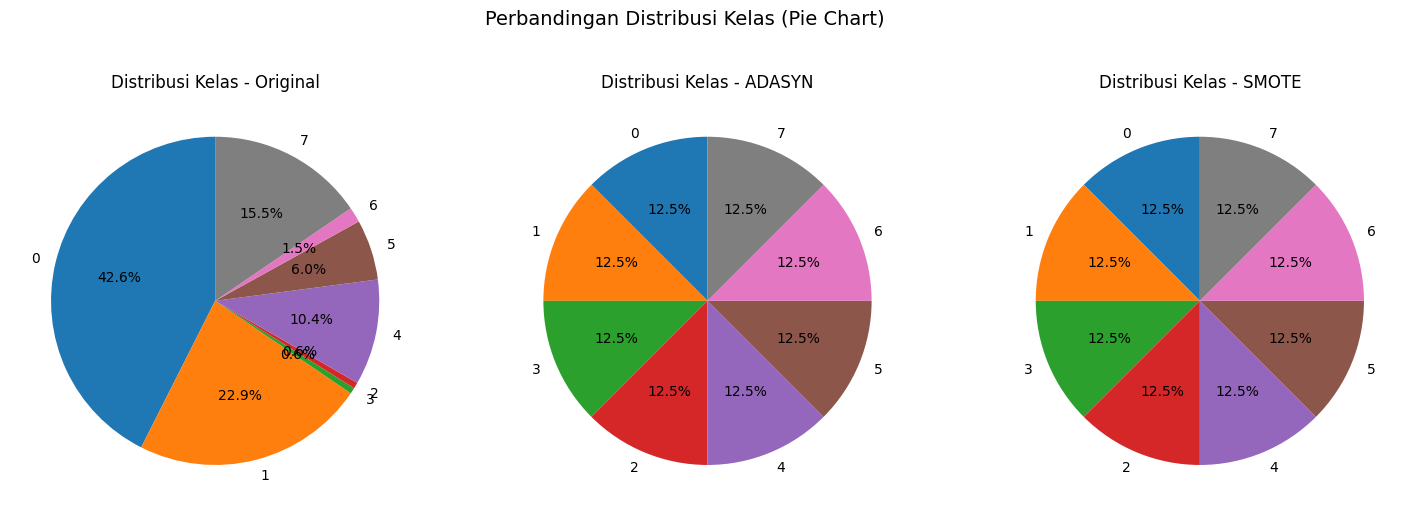

In [18]:
import matplotlib.pyplot as plt

# Data distribusi
dist_before = Counter(y_enc)
dist_adasyn = Counter(y_res)
dist_smote = Counter(y_smote)

# Labels kelas
labels = list(dist_before.keys())

# Figure dengan 3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# Pie chart Original
axes[0].pie(
    [dist_before[k] for k in labels],
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab10.colors
)
axes[0].set_title("Distribusi Kelas - Original")

# Pie chart ADASYN
axes[1].pie(
    [dist_adasyn.get(k, 0) for k in labels],
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab10.colors
)
axes[1].set_title("Distribusi Kelas - ADASYN")

# Pie chart SMOTE
axes[2].pie(
    [dist_smote.get(k, 0) for k in labels],
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab10.colors
)
axes[2].set_title("Distribusi Kelas - SMOTE")

plt.suptitle("Perbandingan Distribusi Kelas (Pie Chart)", fontsize=14)
plt.show()